<a href="https://colab.research.google.com/github/heyday1006/2D-Lidar-DNN/blob/main/Laser_ResNet_Loop_Closure_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


# Section 1: Data Extraction

Data is saved to multiple csv files.

In [2]:
!gdown --id 1Um1qJ_t8v4J10XsxMM97yhOkpr3gnqqc

Downloading...
From: https://drive.google.com/uc?id=1Um1qJ_t8v4J10XsxMM97yhOkpr3gnqqc
To: /content/closure0220.zip
2.30GB [00:14, 162MB/s]


In [3]:
import zipfile
dir_name='closure0220' #'data_pickle.zip'
local_zip = dir_name+'.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(dir_name)
zip_ref.close()

In [4]:
!pip3 install pickle5

In [5]:
import pickle5 as pickle
def read_from_pickle(dir_name,type_name):
  with open(dir_name+'/'+dir_name+'/'+type_name+'_range_pairs.pickle', 'rb') as handle:
      range_pairs_all = pickle.load(handle)

  with open(dir_name+'/'+dir_name+'/'+type_name+'_pose_rels.pickle', 'rb') as handle:
      pose_rels_all = pickle.load(handle)
  range_pairs = np.swapaxes(range_pairs_all, 1, 2)
  translation_rels=np.round(np.double(pose_rels_all[:,0:2]),4)
  rotation_rels=np.double(pose_rels_all[:,2])
  print("for %s dataset",type_name)
  print("size of range_pairs: ", range_pairs.shape)
  print("size of pose_rels: ", translation_rels.shape)
  print("size of rotation_rels: ", rotation_rels.shape)
  print("<------------->")
  return range_pairs,translation_rels,rotation_rels

range_pairs,pose_rels,rotation_rels = read_from_pickle(dir_name,'train')

for %s dataset train
size of range_pairs:  (238200, 1081, 2)
size of pose_rels:  (238200, 2)
size of rotation_rels:  (238200,)
<------------->


## Design loop closure condition

In [6]:
from numpy import linalg as LA
import math
# pose_rels=np.double(pose_rels_all[:,0:2])
# rotation_rels=np.double(pose_rels_all[:,2])

pose_rels_norm=LA.norm(pose_rels, axis=1)
closure_indices=np.where((pose_rels_norm<0.3) & (np.abs(rotation_rels)<100*np.pi/180))
closure_mask=np.zeros((pose_rels.shape[0],1),dtype=bool)
closure_mask[closure_indices,:]=True
closure_label=closure_mask

In [7]:
#too many zeros!!!
from numpy import linalg as LA
import math
# range_pairs = np.double(np.swapaxes(range_pairs_all, 1, 2))
# pose_rels=np.double(pose_rels_all[:,0:2])
# rotation_rels=np.double(pose_rels_all[:,2])

pose_rels_norm=LA.norm(pose_rels, axis=1)
nonzeros_indices=np.where((pose_rels_norm>1e-4) | (LA.norm(rotation_rels, axis=0)>1e-4))
nonfar_indices=np.where((rotation_rels<=1.0) & (rotation_rels>=-1.0) )
chosen_indices=np.intersect1d(nonzeros_indices,nonfar_indices)
pose_rels=pose_rels[chosen_indices]
rotation_rels=rotation_rels[chosen_indices]
range_pairs=range_pairs[chosen_indices]
closure_labels=closure_label[chosen_indices]
print("size of pose_rels: ", pose_rels.shape)

size of pose_rels:  (189314, 2)


Binary class distribution

In [8]:
neg, pos = np.bincount(np.array(closure_labels[:,0]))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 189314
    Positive: 84094 (44.42% of total)



## Compressive Sensing

In [9]:
import random
Flag_compression=False
if Flag_compression:
  percent_compresed=0.1
  indices_pre=np.array(random.sample(range(1,539),np.int(1079*percent_compresed/2)))
  indices_pre=np.append(2*indices_pre,2*indices_pre+1)
  print(np.shape(indices_pre))
  indices=np.array(np.append(1,np.sort(indices_pre),1081))
  range_pairs_compressed=np.array(range_pairs.copy())#=range_pairs[:,indices,:]
  mask=np.ones(range_pairs_compressed.shape,dtype=bool)
  mask[:,indices,:]=False
  range_pairs_compressed[mask]=0
else:
  range_pairs_compressed=range_pairs

  print("size of range_pairs_compressed: ", range_pairs_compressed.shape)
  

size of range_pairs_compressed:  (189314, 1081, 2)


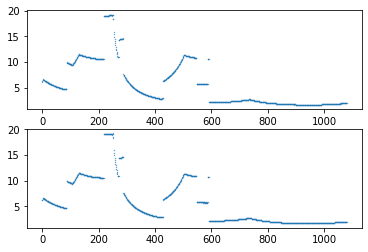

In [10]:
plt.figure(1)
plt.subplot(211)
plt.scatter([range(1081)], [range_pairs[500,:,1]], s=0.1, label="original")
plt.subplot(212)
plt.scatter([range(1081)], [range_pairs_compressed[500,:,1]], s=0.1, label="compressive")
if Flag_compression:
  for xc in indices:
    plt.axvline(x=xc,c='r',linewidth=0.1,linestyle='-.')
    
plt.show()

# Section 2: Data Preparation

In [11]:
from sklearn.utils import shuffle
#print(np.shape(range_pairs_compressed),np.shape(pose_rels_grid),np.shape(rotation_rels_grid),np.shape(pose_rels_grid_all),np.shape(pose_rels_all))
xs, ys, ys_ground_truth = shuffle(range_pairs_compressed, np.double(closure_labels), np.double(closure_labels)) #shuffling the dataset
xs=np.clip(xs, a_min=None, a_max=40)    #remove the inf value of range to a large number

percent_of_trainSet=0.99*0.85
percent_of_validationSet=0.99*0.15
percent_of_testSet=0.01
num_of_trainSet=np.int(ys.shape[0]*percent_of_trainSet)
num_of_validationSet=np.int(ys.shape[0]*percent_of_validationSet)
num_of_testSet=np.int(ys.shape[0]*percent_of_testSet)

x_training = np.array(xs[0:num_of_trainSet], dtype=float)
y_training = np.array(ys[0:num_of_trainSet], dtype=float)
y_training_ground_truth = np.array(ys_ground_truth[0:num_of_trainSet], dtype=float)
print('Size of training data: ', x_training.shape)
print('Size of training labels: ',y_training.shape)

x_validation = np.array(xs[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
y_validation = np.array(ys[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
y_validation_ground_truth = np.array(ys_ground_truth[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
print('Size of validation data: ', x_validation.shape)
print('Size of validation labels: ',y_validation.shape)

x_testing = np.array(xs[num_of_trainSet+num_of_validationSet:], dtype=float)
y_testing = np.array(ys[num_of_trainSet+num_of_validationSet:], dtype=float)
y_testing_ground_truth=np.array(ys_ground_truth[num_of_trainSet+num_of_validationSet:], dtype=float)
print('Size of testing data: ', x_testing.shape)
print('Size of testing labels: ',y_testing.shape)

Size of training data:  (159307, 1081, 2)
Size of training labels:  (159307, 1)
Size of validation data:  (28113, 1081, 2)
Size of validation labels:  (28113, 1)
Size of testing data:  (1894, 1081, 2)
Size of testing labels:  (1894, 1)


# Section 3: Model Traning

In [12]:
BATCH_SIZE = 32
training_dataset = tf.data.Dataset.from_tensor_slices((x_training,y_training)).batch(BATCH_SIZE)#
validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, y_validation)).batch(BATCH_SIZE)

In [13]:
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Add, AveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras import Model
def residual_block(x):
      temp = x
      x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
      x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
      x = Add()([Activation('relu')(x), temp])
      return x

def Res1DFlat_Pose(dropout_rate,input_shape):
  # input size = (batch_size, 2, 1081)
  input_data = Input(shape=input_shape)
  #x = Dense(1024, activation='relu')(1081)
  # first resnet block
  x = Conv1D(filters=64, kernel_size=7, strides=3, activation='relu', padding='same')(input_data)
  x = MaxPooling1D(pool_size=3)(x)
  x=residual_block(x)
  # second resnet block
  x=residual_block(x)
  # third resnet block
  x=residual_block(x)
  # fourth resnet block
  x=residual_block(x)
  # fifth resnet block
  x=residual_block(x)

  # Average pooling
  x = AveragePooling1D(pool_size=7)(x)
  x = Flatten()(x) # (batch_size, 2, channel)

  # Dense Layers
  x = Dense(1024, activation='relu')(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(dropout_rate)(x)

  x1 = Dense(512, activation='relu')(x)
  x1 = Dropout(dropout_rate)(x1)
  #output1 = Dense(2786, activation='softmax', name='pose')(x1)
  output1 = Dense(2, activation=None, name='pose')(x1)

  x2 = Dense(512, activation='relu')(x)
  x2 = Dropout(dropout_rate)(x2)
  output2 = Dense(1, activation=None,name='rotation')(x2)
  #x2 = Dense(230, activation='softmax')(x2)
  #output2 = SoftArgmax(name='rotation')(x2,10)#Dense(230, activation='softmax', name='rotation')(x2)

  model = Model(inputs=input_data, outputs=[output1, output2])
  return model

In [14]:
!gdown --id 1fj_Mw6XlVgHq7ECDp5mEkey7OT8iqUOV
local_zip = 'model_weights0307.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('model_weights0307')
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1fj_Mw6XlVgHq7ECDp5mEkey7OT8iqUOV
To: /content/model_weights0307.zip
28.2MB [00:00, 89.9MB/s]


In [15]:
import tensorflow.keras.backend as kb
from tensorflow.keras.losses import MSE
from tensorflow import stack,argmax,cast

dropout_rate=0.2
optimizer_lr=0.001
pose_model = Res1DFlat_Pose(dropout_rate,np.shape(x_training[0]))
pose_model.load_weights('model_weights0307/model_weights0307/base_model_weights')


In [16]:
#pose_model.summary()

In [17]:
def Res1DFlat_Detection(pose_model,dropout_rate):
  x = pose_model.layers[-11].output
  # Dense Layers
  x = Dense(1024, activation='relu')(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(dropout_rate)(x)

  x3 = Dense(512, activation='relu')(x)
  x3 = Dropout(dropout_rate)(x3)
  output3 = Dense(1, activation='sigmoid',name='closure')(x3)

  detection_model = Model(inputs=pose_model.input, outputs=[output3])
  return detection_model

In [18]:
for i in range(len(pose_model.layers[0:-10])):
  pose_model.layers[i].trainable=False
detection_model = Res1DFlat_Detection(pose_model,dropout_rate)

optimizer = tf.keras.optimizers.Adam(optimizer_lr)
detection_model.compile(optimizer=optimizer,
              loss={ "closure":keras.losses.BinaryCrossentropy()},#sparse_categorical_crossentropy,losses.mse},
              metrics={ "closure":[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()]})#SparseCategoricalAccuracy,MeanAbsoluteError()})
detection_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1081, 2)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 361, 64)      960         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 120, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 120, 64)      12352       max_pooling1d[0][0]              
____________________________________________________________________________________________

In [19]:
# lr decay function
def lr_decay(epoch):
  return 0.001 * math.pow(0.9, np.floor(epoch/5))
# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

EPOCHS=50
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=7, restore_best_weights=True, verbose=1)
detection_model.fit(training_dataset, validation_data=validation_dataset, epochs=EPOCHS, callbacks=[early_stopper,lr_decay_callback])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
4979/4979 [==============================] - 96s 18ms/step - loss: 0.2233 - binary_accuracy: 0.9043 - precision: 0.9022 - recall: 0.8790 - auc: 0.9652 - val_loss: 0.1110 - val_binary_accuracy: 0.9534 - val_precision: 0.9345 - val_recall: 0.9621 - val_auc: 0.9927
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
4979/4979 [==============================] - 69s 14ms/step - loss: 0.0964 - binary_accuracy: 0.9621 - precision: 0.9535 - recall: 0.9616 - auc: 0.9938 - val_loss: 0.0835 - val_binary_accuracy: 0.9654 - val_precision: 0.9506 - val_recall: 0.9722 - val_auc: 0.9955
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
4979/4979 [==============================] - 39s 8ms/step - loss: 0.0726 - binary_accuracy: 0.9712 - precision: 0.9647 - recall: 0.9708 - auc: 0.9963 - val_loss: 0.0777 - val_binary_accuracy: 0.9687 - val_precision: 0.9551 - val_recal

# Section 4: Model Evaluation

In [20]:
detection_model.evaluate(validation_dataset)

879/879 [==============================] - 5s 6ms/step - loss: 0.0805 - binary_accuracy: 0.9812 - precision: 0.9755 - recall: 0.9822 - auc: 0.9950


[0.08048684149980545,
 0.9811831116676331,
 0.9754929542541504,
 0.9821572303771973,
 0.9949585795402527]

In [21]:
#evaluate model accuracy using testing dataset
testing_dataset = tf.data.Dataset.from_tensor_slices((x_testing, y_testing)).batch(BATCH_SIZE)
detection_model.evaluate(testing_dataset)

60/60 [==============================] - 0s 6ms/step - loss: 0.0785 - binary_accuracy: 0.9820 - precision: 0.9771 - recall: 0.9819 - auc: 0.9946


[0.07854791730642319,
 0.9820485711097717,
 0.977135956287384,
 0.9818621277809143,
 0.99462890625]

In [32]:
testing_range_pairs,testing_translation_rels,testing_rotation_rels = read_from_pickle(dir_name,'test')

testing_translation_rels_norm=LA.norm(testing_translation_rels, axis=1)
testing_closure_indices=np.where((testing_translation_rels_norm<0.3) & (np.abs(testing_rotation_rels)<100*np.pi/180))
testing_closure_mask=np.zeros((testing_translation_rels.shape[0],1),dtype=bool)
testing_closure_mask[testing_closure_indices,:]=True
testing_closure_label=testing_closure_mask

testing_nonzeros_indices=np.where((testing_translation_rels_norm>1e-4) | (LA.norm(testing_rotation_rels,axis=0)>1e-4))
testing_nonfar_indices=np.where((testing_rotation_rels<=1.0) & (testing_rotation_rels>=-1.0) )
testing_chosen_indices=np.intersect1d(testing_nonzeros_indices,testing_nonfar_indices)
testing_translation_rels=testing_translation_rels[testing_chosen_indices]
testing_rotation_rels=testing_rotation_rels[testing_chosen_indices]
testing_range_pairs=testing_range_pairs[testing_chosen_indices]
testing_closure_labels=testing_closure_label[testing_chosen_indices]
print("size of pose_rels: ", testing_translation_rels.shape)

testing_range_pairs_all=np.clip(testing_range_pairs, a_min=None, a_max=40)    #remove the inf value of range to a large number
x_test_new, y_test_new, y_test_new_ground_truth = shuffle(testing_range_pairs_all, np.double(testing_closure_labels), np.double(testing_closure_labels))

x_testing2 = np.array(x_test_new, dtype=float)
y_testing2 = np.array(y_test_new, dtype=float)
y_testing_ground_truth2=np.array(y_test_new, dtype=float)
print('Size of testing data: ', x_testing2.shape)
print('Size of testing labels: ',y_testing2.shape)
testing_dataset2 = tf.data.Dataset.from_tensor_slices((x_testing2, y_testing2)).batch(BATCH_SIZE)
detection_model.evaluate(testing_dataset2)

for %s dataset test
size of range_pairs:  (38830, 1081, 2)
size of pose_rels:  (38830, 2)
size of rotation_rels:  (38830,)
<------------->
size of pose_rels:  (30410, 2)
Size of testing data:  (30410, 1081, 2)
Size of testing labels:  (30410, 1)
951/951 [==============================] - 6s 6ms/step - loss: 0.4570 - binary_accuracy: 0.9195 - precision: 0.9156 - recall: 0.9264 - auc: 0.9599


[0.4570426940917969,
 0.9195001721382141,
 0.9155860543251038,
 0.9264094829559326,
 0.9598717093467712]

In [23]:
testing_neg, testing_pos = np.bincount(np.array(testing_closure_labels[:,0]))
testing_total = testing_neg + testing_pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    testing_total, testing_pos, 100 * testing_pos / testing_total))

Examples:
    Total: 30410
    Positive: 15396 (50.63% of total)



In [24]:
y_testing3=y_testing2
x_testing3=x_testing2
y_testing_ground_truth3=y_testing_ground_truth2

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MAE

nSamples=100
y_predict=detection_model.predict(x_testing3)>0.5
print(y_predict.shape)
for i in range(nSamples):
  if i%5==0:
    print("test: ", i, " ground_truth: ", np.round(y_testing_ground_truth3[i],4),
          " predicted: ",y_predict[i])


(30410, 1)
test:  0  ground_truth:  [0.]  predicted:  [False]
test:  5  ground_truth:  [0.]  predicted:  [False]
test:  10  ground_truth:  [1.]  predicted:  [ True]
test:  15  ground_truth:  [1.]  predicted:  [ True]
test:  20  ground_truth:  [0.]  predicted:  [False]
test:  25  ground_truth:  [1.]  predicted:  [False]
test:  30  ground_truth:  [1.]  predicted:  [ True]
test:  35  ground_truth:  [1.]  predicted:  [ True]
test:  40  ground_truth:  [0.]  predicted:  [False]
test:  45  ground_truth:  [0.]  predicted:  [ True]
test:  50  ground_truth:  [0.]  predicted:  [False]
test:  55  ground_truth:  [1.]  predicted:  [ True]
test:  60  ground_truth:  [0.]  predicted:  [False]
test:  65  ground_truth:  [1.]  predicted:  [False]
test:  70  ground_truth:  [1.]  predicted:  [False]
test:  75  ground_truth:  [0.]  predicted:  [False]
test:  80  ground_truth:  [0.]  predicted:  [ True]
test:  85  ground_truth:  [1.]  predicted:  [ True]
test:  90  ground_truth:  [1.]  predicted:  [ True]
tes

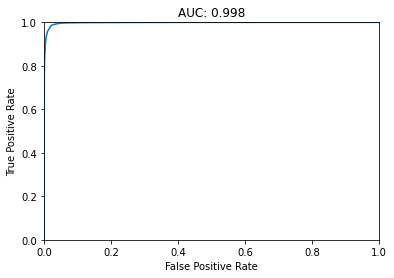

In [26]:
from sklearn.metrics import roc_curve,roc_auc_score

y_val_cat_prob=detection_model.predict(x_validation)
fpr , tpr , thresholds = roc_curve ( y_validation , y_val_cat_prob)
auc_score=roc_auc_score(y_validation,y_val_cat_prob) 
def plot_roc_curve(fpr,tpr,auc_score): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.title('AUC: %.3f' %auc_score)
  plt.show()    
  
plot_roc_curve (fpr,tpr,auc_score)

## Visualize feature map

(7, 2, 64)


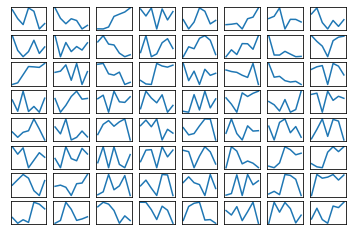

In [28]:
# kernels in first conv layer
filters, biases = detection_model.layers[1].get_weights()
print(np.shape(filters))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.plot(filters[:,0,ix-1])
		ix += 1
# show the figure
plt.show()

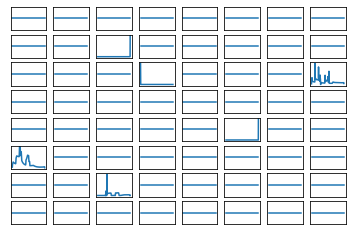

In [31]:
# define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in detection_model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = detection_model.input, outputs = successive_outputs)
# run our image through our network, thus obtaining all
# intermediate representations for this range data.
successive_feature_maps = visualization_model.predict(x_training[0:5])
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in detection_model.layers]
visualization_model = Model(inputs=detection_model.inputs, outputs=detection_model.layers[1].output)
feature_maps = visualization_model.predict(np.expand_dims(x_training[500], axis=0))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.plot(feature_maps[0, :, ix-1])
		ix += 1
# show the figure
plt.show()